In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Create biaised data

In [2]:
from sklearn.datasets import make_classification  # bug in import

n_samples = 30000

X, y = sk.datasets.make_classification(n_classes=3,
                                       n_informative=4,
                                       n_clusters_per_class=1,
                                       n_samples=n_samples,
                                       n_features=12,
                                       flip_y=0.15,
                                       class_sep=0.7,
                                       weights=(0.05, 0.25, 0.70),
                                       random_state=6)

In [3]:
df = pd.DataFrame(X)
df['y'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,y
0,0.064854,-1.229568,-0.184645,0.790684,0.174356,-0.551428,0.932397,-0.228469,0.615568,0.167346,0.018420,-0.711550,1
1,-1.424463,-1.653885,-0.566246,-0.702181,0.191330,2.680241,0.262960,-0.518735,0.507246,0.445566,1.341437,-1.833449,1
2,-0.961987,1.390600,-1.596330,-0.433050,-0.066847,0.621985,-1.026852,-0.892072,-1.611138,-1.292308,-0.819491,0.433991,2
3,0.300879,1.441004,0.126785,0.764954,0.482666,-0.757599,1.117375,3.240408,-0.746224,-0.691515,-0.087435,3.288684,2
4,-1.705402,-1.110542,-1.659716,1.199752,2.048150,-2.060321,1.645812,-0.184889,-0.234704,0.722942,-0.734339,-0.103736,2


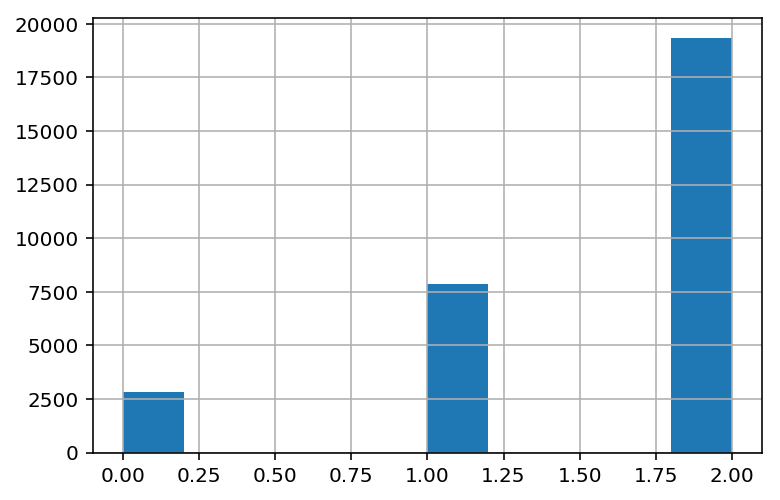

In [4]:
df.y.hist();

In [5]:
df_0_index = df[df.y == 0].index
df_1_index = df[df.y == 1].index
df_2_index = df[df.y == 2].index

In [6]:
number_of_train_by_class = int(df[df.y == 0].index.shape[0] * 0.66)
print(f'number_of_train_by_class: {number_of_train_by_class}')

number_of_train_by_class: 1861


In [7]:
np.random.seed(6)

train_0_index = np.random.choice(df_0_index, number_of_train_by_class, replace=False)
train_1_index = np.random.choice(df_1_index, number_of_train_by_class, replace=False)
train_2_index = np.random.choice(df_2_index, number_of_train_by_class, replace=False)

In [8]:
test_0_index = list(set(df_0_index) - set(train_0_index))
test_1_index = list(set(df_1_index) - set(train_1_index))
test_2_index = list(set(df_2_index) - set(train_2_index))

assert len(train_0_index) + len(test_0_index) == len(df_0_index)
assert len(train_1_index) + len(test_1_index) == len(df_1_index)
assert len(train_2_index) + len(test_2_index) == len(df_2_index)

In [9]:
df_train = df.loc[np.concatenate((train_0_index, train_1_index, train_2_index))]
df_test = df.loc[np.concatenate((test_0_index, test_1_index, test_2_index))]

(5583, 13) (24417, 13)


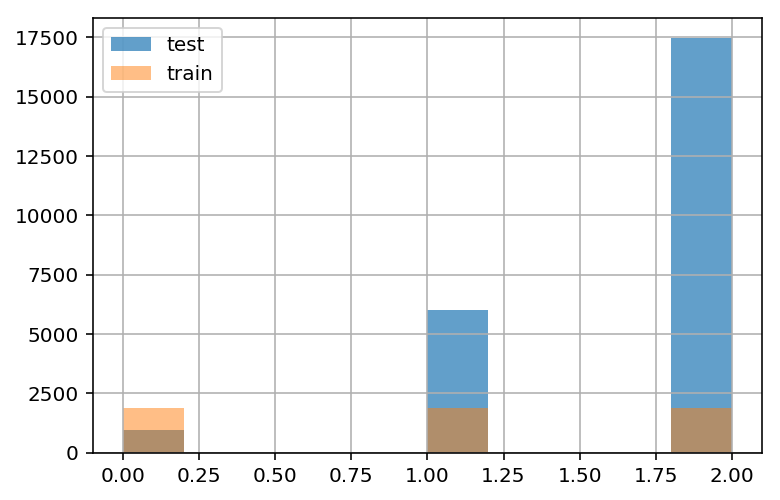

In [10]:
print(df_train.shape, df_test.shape)
df_test.y.hist(alpha = 0.7, label='test')
df_train.y.hist(alpha = 0.5, label='train');
plt.legend();

# xgb model with iterative weights approach

#### 1st model without weights (dummy benchmark)

In [11]:
X_train, X_valid, y_train, y_valid = sk.model_selection.train_test_split(df_train.iloc[:,:-1].values,
                                                                         df_train.y.values,
                                                                         test_size=0.3,
                                                                         random_state=6)

In [12]:
dvaltrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

dtrain = xgb.DMatrix(np.asmatrix(df_train.iloc[:,:-1].values), df_train.y.values)
dtest = xgb.DMatrix(np.asmatrix(df_test.iloc[:,:-1].values))

In [13]:
param = {'max_depth': 4,
         'eta': 1,
         'silent': 1,
         'objective': 'multi:softmax',
         'num_class': 3,
         'eval_metric': 'merror'}

eval_list = [(dvalid, 'eval'), (dvaltrain, 'train')]

eval_clf = xgb.train(param, dvaltrain, num_boost_round=1000, evals=eval_list, early_stopping_rounds=30)

[0]	eval-merror:0.413134	train-merror:0.382037
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 30 rounds.
[1]	eval-merror:0.389851	train-merror:0.346213
[2]	eval-merror:0.392836	train-merror:0.322416
[3]	eval-merror:0.4	train-merror:0.300154
[4]	eval-merror:0.39403	train-merror:0.286592
[5]	eval-merror:0.391642	train-merror:0.283265
[6]	eval-merror:0.389851	train-merror:0.267912
[7]	eval-merror:0.388657	train-merror:0.252303
[8]	eval-merror:0.381493	train-merror:0.237718
[9]	eval-merror:0.385672	train-merror:0.229017
[10]	eval-merror:0.38209	train-merror:0.221597
[11]	eval-merror:0.384478	train-merror:0.216479
[12]	eval-merror:0.392239	train-merror:0.213408
[13]	eval-merror:0.388657	train-merror:0.205732
[14]	eval-merror:0.382687	train-merror:0.198055
[15]	eval-merror:0.386866	train-merror:0.195752
[16]	eval-merror:0.380298	train-merror:0.189099
[17]	eval-merror:0.374925	train-merror:0.182958
[18]

In [14]:
clf = xgb.train(param, dtrain, num_boost_round=eval_clf.best_iteration)

In [15]:
preds = clf.predict(dtest)

In [16]:
sk.metrics.confusion_matrix(df_test.y, preds)

array([[  486,   189,   284],
       [  988,  4252,   758],
       [ 4443,  1761, 11256]])

In [17]:
sk.metrics.accuracy_score(df_test.y, preds)

0.6550354261375272

{0: 0.2423311627145022, 1: 0.2540033583159274, 2: 0.5036654789695704}


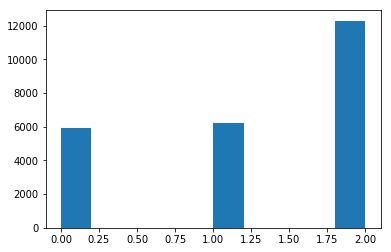

In [18]:
print({i: (preds == i).mean() for i in range(3)})
plt.hist(preds);

#### 2nd model with known weights (prove that it helps improve score)

In [19]:
weights = {i: (df_test.y == i).mean() for i in range(3)}
weights

{0: 0.03927591432198878, 1: 0.2456485235696441, 2: 0.7150755621083671}

In [20]:
df_train['weight'] = [weights[instance] for instance in df_train.y]
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,y,weight
1858,-2.093022,-1.335816,-0.689366,0.189724,0.451269,-0.421503,2.540463,3.476093,0.701723,1.063066,1.647639,1.328214,0,0.039276
19843,0.036719,-1.388249,-0.012698,0.421207,1.033483,0.568398,-1.185841,-4.681751,3.031707,-0.592787,-2.378563,-3.327800,0,0.039276
10123,-0.840337,-0.306798,0.605902,1.824914,-1.345126,-0.571673,1.315350,0.580866,-0.392447,-1.610414,-0.620426,0.760836,0,0.039276
9419,0.935058,0.236338,0.358571,0.029925,-0.921937,2.307908,0.541702,-1.687529,-1.859234,1.462883,-1.994519,0.069353,0,0.039276
3561,-1.049473,-0.387204,-2.121353,1.352331,-1.232544,0.470098,1.007094,-0.409253,1.016515,1.351932,-1.703022,0.366518,0,0.039276


In [21]:
X_train, X_valid, y_train, y_valid = sk.model_selection.train_test_split(df_train.drop('y', axis=1),
                                                                         df_train.y,
                                                                         test_size=0.3,
                                                                         random_state=6)

In [22]:
dvaltrain = xgb.DMatrix(np.asmatrix(X_train.drop('weight', axis=1).values),
                        y_train,
                        weight=X_train.weight.values)
dvalid = xgb.DMatrix(np.asmatrix(X_valid.drop('weight', axis=1)),
                     y_valid,
                     weight=X_valid.weight.values)

dtrain = xgb.DMatrix(df_train.drop(['y', 'weight'], axis=1).values,
                     df_train.y.values,
                     weight=df_train.weight.values)
dtest = xgb.DMatrix(df_test.drop('y', axis=1).values)

In [23]:
param = {'max_depth': 4,
         'eta': 1,
         'silent': 1,
         'objective': 'multi:softmax',
         'num_class': 3,
         'eval_metric': 'merror'}

eval_list = [(dvalid, 'eval'), (dvaltrain, 'train')]

eval_clf = xgb.train(param, dvaltrain, num_boost_round=1000, evals=eval_list, early_stopping_rounds=30)

[0]	eval-merror:0.178186	train-merror:0.15669
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 30 rounds.
[1]	eval-merror:0.165815	train-merror:0.14312
[2]	eval-merror:0.149414	train-merror:0.134626
[3]	eval-merror:0.153035	train-merror:0.127056
[4]	eval-merror:0.149572	train-merror:0.118719
[5]	eval-merror:0.148465	train-merror:0.112184
[6]	eval-merror:0.155661	train-merror:0.110682
[7]	eval-merror:0.156321	train-merror:0.106218
[8]	eval-merror:0.152027	train-merror:0.105226
[9]	eval-merror:0.160108	train-merror:0.101761
[10]	eval-merror:0.161146	train-merror:0.100215
[11]	eval-merror:0.163139	train-merror:0.098138
[12]	eval-merror:0.159921	train-merror:0.093395
[13]	eval-merror:0.161954	train-merror:0.091753
[14]	eval-merror:0.168814	train-merror:0.084221
[15]	eval-merror:0.15991	train-merror:0.082265
[16]	eval-merror:0.161569	train-merror:0.080401
[17]	eval-merror:0.165763	train-merror:0.077295


[168]	eval-merror:0.241734	train-merror:0.006854
[169]	eval-merror:0.245524	train-merror:0.006793
[170]	eval-merror:0.243935	train-merror:0.006672
[171]	eval-merror:0.244834	train-merror:0.006611
[172]	eval-merror:0.245337	train-merror:0.006551
[173]	eval-merror:0.243639	train-merror:0.006278
[174]	eval-merror:0.248694	train-merror:0.006096
[175]	eval-merror:0.248763	train-merror:0.005914
[176]	eval-merror:0.248694	train-merror:0.005823
[177]	eval-merror:0.250717	train-merror:0.005974
[178]	eval-merror:0.249454	train-merror:0.005944
[179]	eval-merror:0.249454	train-merror:0.005823
[180]	eval-merror:0.249857	train-merror:0.005641
[181]	eval-merror:0.252849	train-merror:0.00555
[182]	eval-merror:0.251516	train-merror:0.005459
[183]	eval-merror:0.252454	train-merror:0.005338
[184]	eval-merror:0.251811	train-merror:0.005307
[185]	eval-merror:0.255671	train-merror:0.005186
[186]	eval-merror:0.255098	train-merror:0.005156
[187]	eval-merror:0.256105	train-merror:0.005034
[188]	eval-merror:0.2

[340]	eval-merror:0.287786	train-merror:0
[341]	eval-merror:0.286918	train-merror:0
[342]	eval-merror:0.287786	train-merror:0
[343]	eval-merror:0.289049	train-merror:0
[344]	eval-merror:0.289483	train-merror:0
[345]	eval-merror:0.290382	train-merror:0
[346]	eval-merror:0.28822	train-merror:0
[347]	eval-merror:0.289483	train-merror:0
[348]	eval-merror:0.288476	train-merror:0
[349]	eval-merror:0.28964	train-merror:0
[350]	eval-merror:0.290903	train-merror:0
[351]	eval-merror:0.291733	train-merror:0
[352]	eval-merror:0.290973	train-merror:0
[353]	eval-merror:0.289206	train-merror:0
[354]	eval-merror:0.290539	train-merror:0
[355]	eval-merror:0.291042	train-merror:0
Stopping. Best iteration:
[325]	eval-merror:0.2807	train-merror:0



In [24]:
clf = xgb.train(param, dtrain, num_boost_round=eval_clf.best_iteration)

In [25]:
preds = clf.predict(dtest)

In [26]:
sk.metrics.confusion_matrix(df_test.y, preds)

array([[  355,   224,   380],
       [  534,  4482,   982],
       [ 1949,  1625, 13886]])

In [27]:
sk.metrics.accuracy_score(df_test.y, preds)

0.7668018184052094

{0: 0.03927591432198878, 1: 0.2456485235696441, 2: 0.7150755621083671}
{0: 0.11623049514682393, 1: 0.25928656264078304, 2: 0.624482942212393}


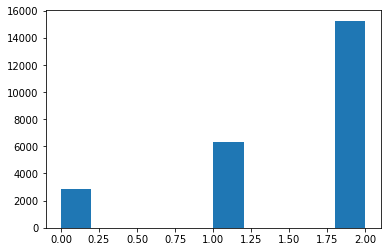

In [28]:
print(weights)
print({i: (preds == i).mean() for i in range(3)})
plt.hist(preds);

#### 3rd model with iterative approach to get weights

In [65]:
df_train.drop('weight', axis=1, inplace=True)

KeyError: "['weight'] not found in axis"

score: 0.6550354261375272
base weights: {0: 0.2423311627145022, 1: 0.2540033583159274, 2: 0.5036654789695704}


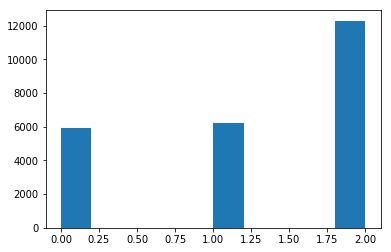

In [68]:
X_train, X_valid, y_train, y_valid = sk.model_selection.train_test_split(df_train.iloc[:,:-1].values,
                                                                         df_train.y.values,
                                                                         test_size=0.3,
                                                                         random_state=6)

dvaltrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

dtrain = xgb.DMatrix(np.asmatrix(df_train.iloc[:,:-1].values), df_train.y.values)
dtest = xgb.DMatrix(np.asmatrix(df_test.iloc[:,:-1].values))

param = {'max_depth': 4,
         'eta': 1,
         'silent': 1,
         'objective': 'multi:softmax',
         'num_class': 3,
         'eval_metric': 'merror'}

eval_list = [(dvalid, 'eval'), (dvaltrain, 'train')]

eval_clf = xgb.train(param, dvaltrain, num_boost_round=1000, evals=eval_list, early_stopping_rounds=30, verbose_eval=False)

clf = xgb.train(param, dtrain, num_boost_round=eval_clf.best_iteration)

preds = clf.predict(dtest)
print('score:', sk.metrics.accuracy_score(df_test.y, preds))

weights = {i: (preds == i).mean() for i in range(3)}
print('base weights:', weights)
plt.hist(preds);

score: 0.7190482041200803
base weights: {0: 0.2423311627145022, 1: 0.2540033583159274, 2: 0.5036654789695704}
new weights: {0: 0.18032518327394848, 1: 0.2426588032927878, 2: 0.5770160134332637}
score: 0.7387475938895032
base weights: {0: 0.18032518327394848, 1: 0.2426588032927878, 2: 0.5770160134332637}
new weights: {0: 0.15898759061309745, 1: 0.24515706270221566, 2: 0.5958553466846869}
score: 0.7371913011426465
base weights: {0: 0.15898759061309745, 1: 0.24515706270221566, 2: 0.5958553466846869}
new weights: {0: 0.16038006307081132, 1: 0.2425359380759307, 2: 0.597083998853258}
score: 0.7439898431420732
base weights: {0: 0.16038006307081132, 1: 0.2425359380759307, 2: 0.597083998853258}
new weights: {0: 0.14604578777081542, 1: 0.24998976123192856, 2: 0.603964450997256}
score: 0.7455051808166442
base weights: {0: 0.14604578777081542, 1: 0.24998976123192856, 2: 0.603964450997256}
new weights: {0: 0.14440758487938732, 1: 0.25003071630421425, 2: 0.6055616988163984}


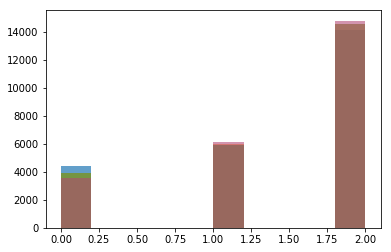

In [69]:
for _ in range(5):
    df_train['weight'] = [weights[instance] for instance in df_train.y]
    X_train, X_valid, y_train, y_valid = sk.model_selection.train_test_split(df_train.drop('y', axis=1),
                                                                             df_train.y,
                                                                             test_size=0.3,
                                                                             random_state=6)
    dvaltrain = xgb.DMatrix(np.asmatrix(X_train.drop('weight', axis=1).values),
                            y_train,
                            weight=X_train.weight.values)
    dvalid = xgb.DMatrix(np.asmatrix(X_valid.drop('weight', axis=1)),
                         y_valid,
                         weight=X_valid.weight.values)

    dtrain = xgb.DMatrix(df_train.drop(['y', 'weight'], axis=1).values,
                         df_train.y.values,
                         weight=df_train.weight.values)
    dtest = xgb.DMatrix(df_test.drop('y', axis=1).values)

    eval_list = [(dvalid, 'eval'), (dvaltrain, 'train')]

    eval_clf = xgb.train(param, dvaltrain, num_boost_round=1000, evals=eval_list, early_stopping_rounds=30, verbose_eval=False)

    clf = xgb.train(param, dtrain, num_boost_round=eval_clf.best_iteration)

    preds = clf.predict(dtest)
    print('score:', sk.metrics.accuracy_score(df_test.y, preds))

    print('base weights:', weights)
    weights = {i: (preds == i).mean() for i in range(3)}
    print('new weights:', weights)
    plt.hist(preds, alpha=0.7 - _*0.1)
    
    df_train.drop('weight', axis=1, inplace=True)